In [1]:
import numpy as np
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler, PowerTransformer

## Load dataset

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings']

# Load the dataset
df = pd.read_csv(url, header=None, names=columns)
df

sex  length  diameter  height  whole_weight  shucked_weight  \
0      M   0.455     0.365   0.095        0.5140          0.2245   
1      M   0.350     0.265   0.090        0.2255          0.0995   
2      F   0.530     0.420   0.135        0.6770          0.2565   
3      M   0.440     0.365   0.125        0.5160          0.2155   
4      I   0.330     0.255   0.080        0.2050          0.0895   
...   ..     ...       ...     ...           ...             ...   
4172   F   0.565     0.450   0.165        0.8870          0.3700   
4173   M   0.590     0.440   0.135        0.9660          0.4390   
4174   M   0.600     0.475   0.205        1.1760          0.5255   
4175   F   0.625     0.485   0.150        1.0945          0.5310   
4176   M   0.710     0.555   0.195        1.9485          0.9455   

      viscera_weight  shell_weight  rings  
0             0.1010        0.1500     15  
1             0.0485        0.0700      7  
2             0.1415        0.2100      9  
3             0.1140        0.1550     10  
4             0.0395        0.0550      7  
...              ...           ...    ...  
4172          0.2390        0.2490     11  
4173          0.2145        0.2605     10  
4174          0.2875        0.3080      9  
4175          0.2610        0.2960     10  
4176          0.3765        0.4950     12  

[4177 rows x 9 columns]

In [3]:
np.mean(df['rings'])

9.933684462532918

# EDA

#### check for inconsistencies in non numerical values

In [4]:
df.sex.unique()

array(['M', 'F', 'I'], dtype=object)

#### one hot encode non numerical values

In [5]:
df.sex = df.sex.replace('M', 0)
df.sex = df.sex.replace('F', 1)
df.sex = df.sex.replace('I', 2)

#### check for null values

In [6]:
df.isnull().sum()

sex               0
length            0
diameter          0
height            0
whole_weight      0
shucked_weight    0
viscera_weight    0
shell_weight      0
rings             0
dtype: int64

#### visualize relations with rings attribute (our predicted value) to uncover possible inconsistencies

<AxesSubplot: xlabel='rings', ylabel='length'>

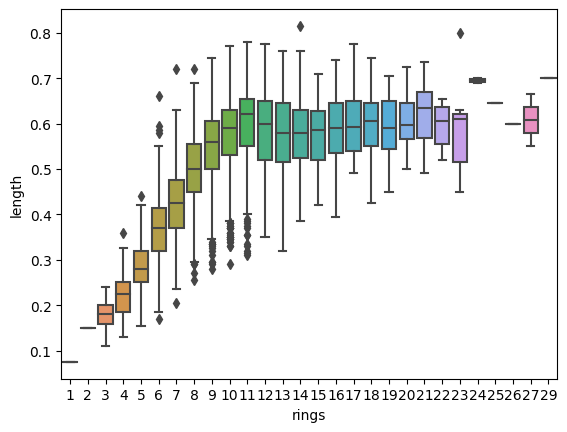

In [7]:
sns.boxplot(x='rings', y="length", data=df)

<AxesSubplot: xlabel='rings', ylabel='diameter'>

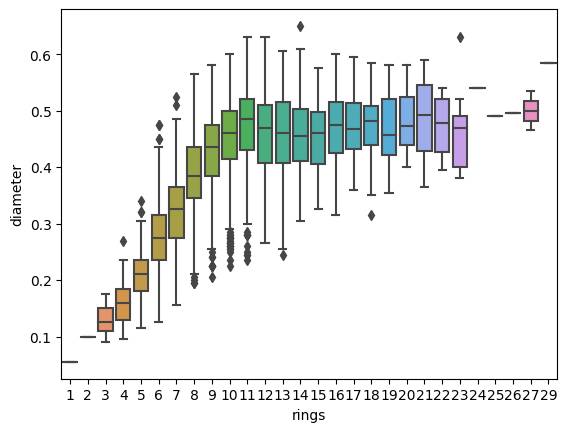

In [8]:
sns.boxplot(x='rings', y="diameter", data=df)

<AxesSubplot: xlabel='rings', ylabel='height'>

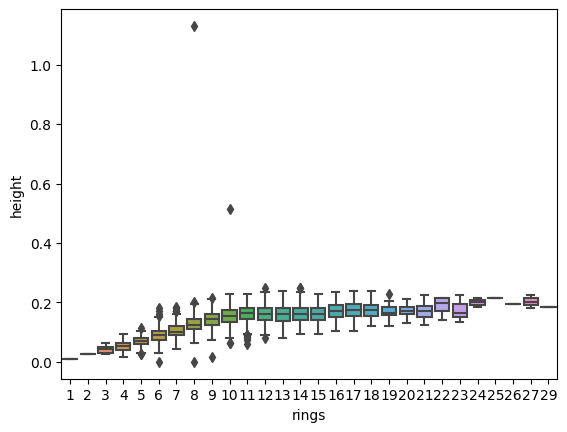

In [9]:
sns.boxplot(x='rings', y="height", data=df)

<AxesSubplot: xlabel='rings', ylabel='whole_weight'>

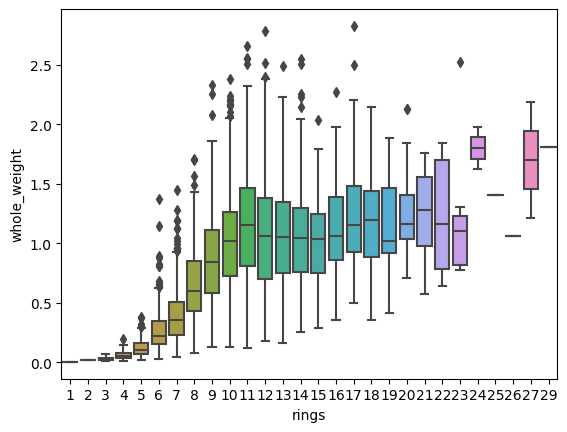

In [10]:
sns.boxplot(x='rings', y="whole_weight", data=df)

<AxesSubplot: xlabel='rings', ylabel='shucked_weight'>

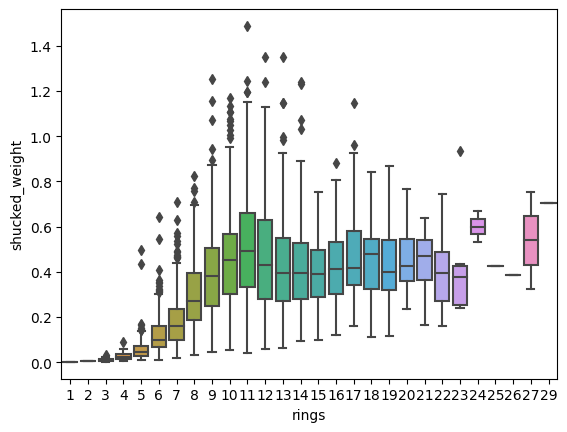

In [11]:
sns.boxplot(x='rings', y="shucked_weight", data=df)

<AxesSubplot: xlabel='rings', ylabel='viscera_weight'>

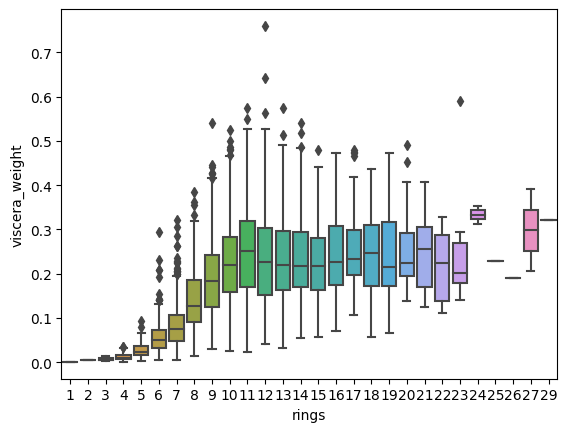

In [12]:
sns.boxplot(x='rings', y="viscera_weight", data=df)

<AxesSubplot: xlabel='rings', ylabel='shell_weight'>

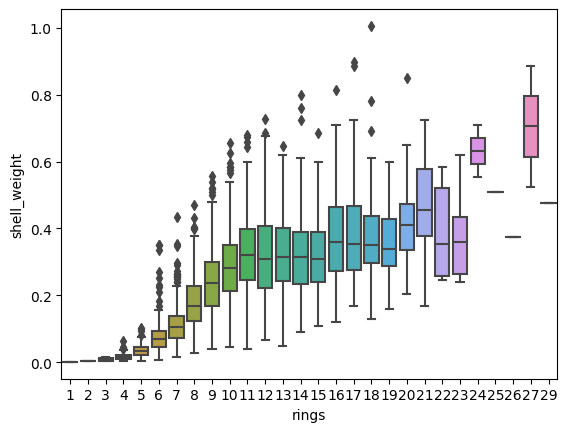

In [13]:
sns.boxplot(x='rings', y="shell_weight", data=df)

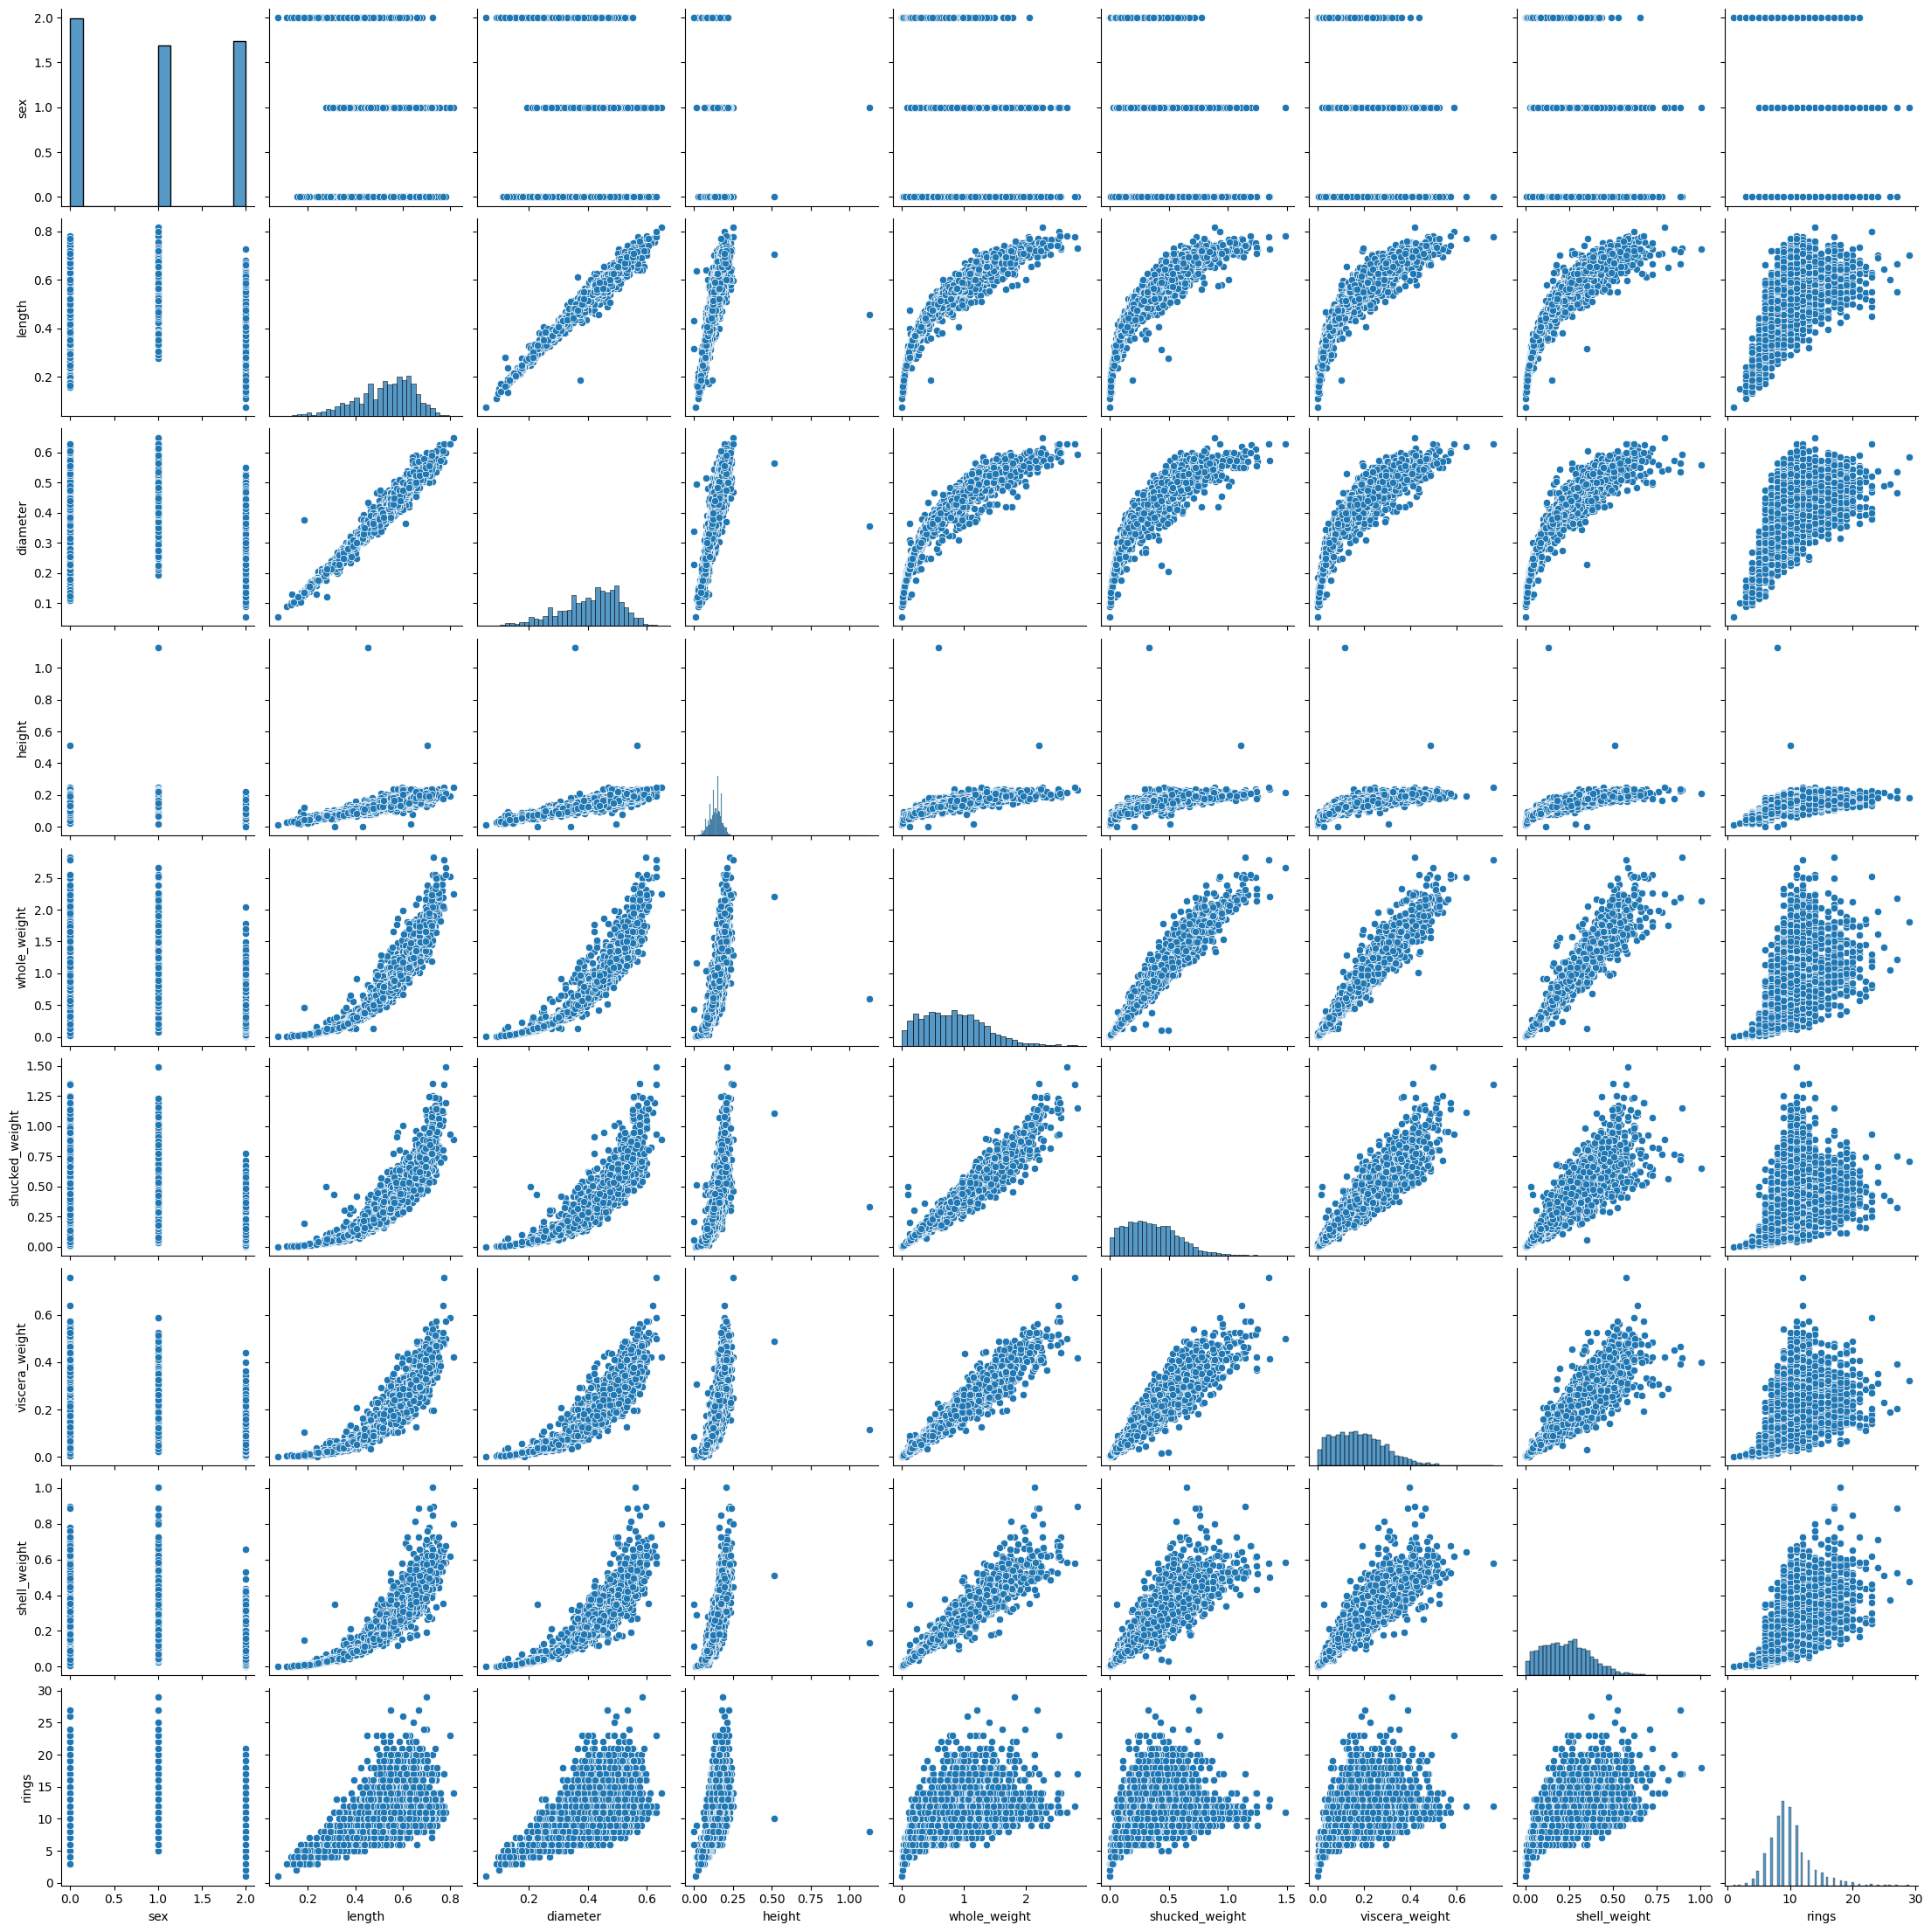

In [14]:
sns.pairplot(df[df.columns])

## Correlation

<AxesSubplot: >

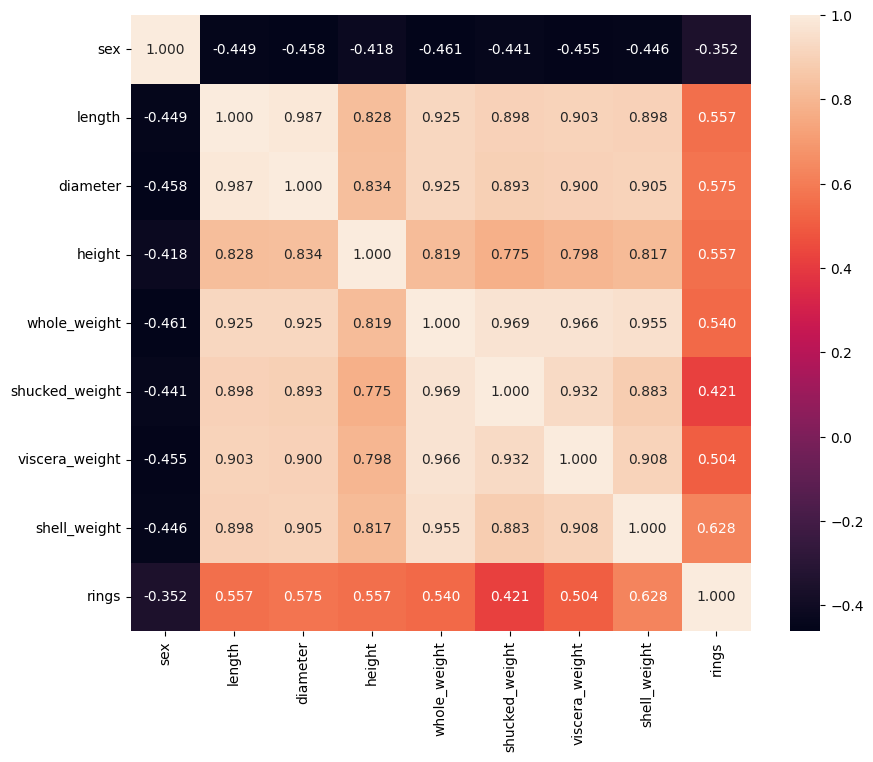

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr(), ax=ax, annot=True, fmt=".3f")

As can be seen from the heatmap and pairplots above, all attributes have similar impact in the predict value (**rings**). The tendecy is that rings number grows with increase in each attribude, excluding **sex**. Male sex is being encoded as **0**, while Female as **1** and Infant as **2**, which means that males mostly have more rings than females, who have more of them than infants.

## Outliers

#### function to find lower and upper allowed boundary for outliers

In [16]:
def identify_outliers(data):
    lower = data.quantile(0.05) - 1.5 * stats.iqr(data)
    upper = data.quantile(0.95) + 1.5 * stats.iqr(data)

    return lower, upper, len(data[(data < lower) | (data > upper)])

#### change all outlier values for the corresponding boundary 

In [17]:
def outlierMean(df):
    for col in df.columns[:-1]:
        lower, upper, num_outliers = identify_outliers(df[col])
        print(f"lower:{lower}, upper:{upper}")
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
        print(f"{num_outliers} values modified for {col}")
    return df

In [18]:
df.describe()

sex       length     diameter       height  whole_weight  \
count  4177.000000  4177.000000  4177.000000  4177.000000   4177.000000   
mean      0.955470     0.523992     0.407881     0.139516      0.828742   
std       0.827815     0.120093     0.099240     0.041827      0.490389   
min       0.000000     0.075000     0.055000     0.000000      0.002000   
25%       0.000000     0.450000     0.350000     0.115000      0.441500   
50%       1.000000     0.545000     0.425000     0.140000      0.799500   
75%       2.000000     0.615000     0.480000     0.165000      1.153000   
max       2.000000     0.815000     0.650000     1.130000      2.825500   

       shucked_weight  viscera_weight  shell_weight        rings  
count     4177.000000     4177.000000   4177.000000  4177.000000  
mean         0.359367        0.180594      0.238831     9.933684  
std          0.221963        0.109614      0.139203     3.224169  
min          0.001000        0.000500      0.001500     1.000000  
25%          0.186000        0.093500      0.130000     8.000000  
50%          0.336000        0.171000      0.234000     9.000000  
75%          0.502000        0.253000      0.329000    11.000000  
max          1.488000        0.760000      1.005000    29.000000

In [19]:
df = outlierMean(df)

lower:-3.0, upper:5.0
0 values modified for sex
lower:0.047500000000000014, upper:0.9374999999999999
0 values modified for length
lower:0.024999999999999994, upper:0.74
0 values modified for diameter
lower:-1.3877787807814457e-17, upper:0.275
2 values modified for height
lower:-0.94135, upper:2.7621499999999988
2 values modified for whole_weight
lower:-0.4216, upper:1.2142
8 values modified for shucked_weight
lower:-0.21225000000000002, upper:0.6188499999999999
2 values modified for viscera_weight
lower:-0.2601, upper:0.7785
8 values modified for shell_weight


There are not many outliers found, if the edge values are calculated as `5-perc - 1.5 * IQR` and `95-perc + 1.5 * IQR`. Since dataset we have is not very large, outliers were substituted with the corresponding edge values, so the changed dataset will be as close to the original as possible.

In [20]:
df.describe()

sex       length     diameter       height  whole_weight  \
count  4177.000000  4177.000000  4177.000000  4177.000000   4177.000000   
mean      0.955470     0.523992     0.407881     0.139254      0.828723   
std       0.827815     0.120093     0.099240     0.038595      0.490312   
min       0.000000     0.075000     0.055000     0.000000      0.002000   
25%       0.000000     0.450000     0.350000     0.115000      0.441500   
50%       1.000000     0.545000     0.425000     0.140000      0.799500   
75%       2.000000     0.615000     0.480000     0.165000      1.153000   
max       2.000000     0.815000     0.650000     0.275000      2.762150   

       shucked_weight  viscera_weight  shell_weight        rings  
count     4177.000000     4177.000000   4177.000000  4177.000000  
mean         0.359204        0.180554      0.238667     9.933684  
std          0.221269        0.109435      0.138482     3.224169  
min          0.001000        0.000500      0.001500     1.000000  
25%          0.186000        0.093500      0.130000     8.000000  
50%          0.336000        0.171000      0.234000     9.000000  
75%          0.502000        0.253000      0.329000    11.000000  
max          1.214200        0.618850      0.778500    29.000000

#### power scale the dataset

In [21]:
def powerScale(df, features):
    power = PowerTransformer(
        method='yeo-johnson', 
        standardize=True
    )
    # for col in df.columns:
    #     plots(df, col, power)
    df[df.columns] = power.fit_transform(features.values)
   
    return df

#### split dataset into train and test set

In [22]:
from sklearn.model_selection import train_test_split


# Split the dataset into input features and target labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X[X.select_dtypes(include=['float64']).columns] = X.select_dtypes(include=['float64']).astype('float32')
# X['sex'] = X['sex'].map({'M': 0, 'F': 1, 'I': 2}).astype('float32')
X = powerScale(X, X)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

Dataset was split by ratio 8:2 (train:test), since our dataset is not very big and we need enough data for testing and validation as well.

## Tensorflow

Hyperparameter tuning process was done using tensorflow library functions and layers. To speed-up training, GPU strategy has been used as well. 

In [23]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD

print("Available devices: %s" % tf.config.list_physical_devices())

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
def build_model(hidden_size=64, learning_rate=0.01, dropout=0.2):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_size, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(hidden_size/2, activation='relu'),
        tf.keras.layers.Dense(hidden_size/4, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate)

    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

Model consists of 5 different layers (excluding input layer):

    1. Dense (first hidden)
    2. Dropout (to avoid overfitting)
    3. Dense (second hidden)
    4. Dense (third hidden)
    5. Output (Dense)
    
With such an architecture, model is able to detect more- and less-abstract patterns in the data (relations between different columns). Dropout is used to avoid overfitting, since model was trained with 1000 epochs.

In [25]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import EarlyStopping

# Set up early stopping
# Stop run if there is no val_loss improvement over 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)


def train():
    # default hyperparameters
    config_defaults = {
        'learning_rate': 0.01,
        'hidden_size': 64,
        'batch_size':128,
        'dropout': 0.2
    }
    wandb.init(config=config_defaults)
    
    wandb_cb = WandbCallback()

    # Configure the model
    config = wandb.config
    with strategy.scope():
        model = build_model(hidden_size=config.hidden_size, learning_rate=config.learning_rate, dropout=config.dropout)

        # Train the model
        history = model.fit(
            X_train, 
            y_train, 
            validation_split=0.2, 
            epochs=1000, 
            batch_size=config.batch_size, 
            verbose=0, 
            callbacks=[
                early_stop,
                wandb_cb
            ])

    # Log the results
    metrics = {
        'val_loss': history.history['val_loss'][-1],
        'val_mae': history.history['val_mae'][-1]
    }
    wandb.log(metrics)

Early stop was set to observe validation loss metric value. If it will not get better during any 5 epochs in a row, then the run will be stopped. It saves time when training models with many epochs and helps to avoid overfitting as well.

In [26]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_mae',
        'goal': 'minimize'
    },
    'parameters': {
        'hidden_size': {
            'values': [16, 32, 64]
        },
        'learning_rate': {
            'min': 0.001,
            'max': 0.1
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'batch_size': {
            'values': [64, 128]
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

wandb.agent(sweep_id, function=train, count=10)

Create sweep with ID: g5046tns
Sweep URL: https://wandb.ai/xkretinin/uncategorized/sweeps/g5046tns


wandb: Agent Starting Run: jl7enub5 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	hidden_size: 16
wandb: 	learning_rate: 0.06616310767947935
wandb: Currently logged in as: xkretinin. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
C:\Users\kreti\.conda\envs\condaProject\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222141-jl7enub5\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222141-jl7enub5\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222141-jl7enub5\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222141-jl7enub5\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222141-jl7enub5\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222141-jl7enub5\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222141-jl7enub5\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222141-jl7enub5\files\model-best)... Done. 0.0s


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hojldp9t with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	hidden_size: 16
wandb: 	learning_rate: 0.09767427706408298


C:\Users\kreti\.conda\envs\condaProject\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222213-hojldp9t\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222213-hojldp9t\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222213-hojldp9t\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222213-hojldp9t\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222213-hojldp9t\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222213-hojldp9t\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222213-hojldp9t\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222213-hojldp9t\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222213-hojldp9t\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222213-hojldp9t\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222213-hojldp9t\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222213-hojldp9t\files\model-best)... Done. 0.0s


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: atlrpsqe with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.025164940131974796


C:\Users\kreti\.conda\envs\condaProject\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222249-atlrpsqe\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222249-atlrpsqe\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222249-atlrpsqe\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222249-atlrpsqe\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222249-atlrpsqe\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222249-atlrpsqe\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222249-atlrpsqe\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222249-atlrpsqe\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222249-atlrpsqe\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222249-atlrpsqe\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222249-atlrpsqe\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222249-atlrpsqe\files\model-best)... Done. 0.0s


wandb: Agent Starting Run: anyum5iw with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.08582084469693446


C:\Users\kreti\.conda\envs\condaProject\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222317-anyum5iw\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222317-anyum5iw\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222317-anyum5iw\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222317-anyum5iw\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222317-anyum5iw\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222317-anyum5iw\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222317-anyum5iw\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222317-anyum5iw\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222317-anyum5iw\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222317-anyum5iw\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222317-anyum5iw\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222317-anyum5iw\files\model-best)... Done. 0.0s


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yrkauw32 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.03470341506770139


C:\Users\kreti\.conda\envs\condaProject\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222353-yrkauw32\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222353-yrkauw32\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222353-yrkauw32\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222353-yrkauw32\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222353-yrkauw32\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222353-yrkauw32\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222353-yrkauw32\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222353-yrkauw32\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222353-yrkauw32\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222353-yrkauw32\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222353-yrkauw32\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222353-yrkauw32\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222353-yrkauw32\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222353-yrkauw32\files\model-best)... Done. 0.0s


wandb: Agent Starting Run: k6wha002 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.024841375566077337


C:\Users\kreti\.conda\envs\condaProject\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222426-k6wha002\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222426-k6wha002\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222426-k6wha002\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222426-k6wha002\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222426-k6wha002\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222426-k6wha002\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222426-k6wha002\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222426-k6wha002\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222426-k6wha002\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222426-k6wha002\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222426-k6wha002\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222426-k6wha002\files\model-best)... Done. 0.1s


wandb: Agent Starting Run: 7sib432h with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.017293610299784202


C:\Users\kreti\.conda\envs\condaProject\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222453-7sib432h\files\model-best)... Done. 0.0s


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wbggsb0o with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.004019080222959043


C:\Users\kreti\.conda\envs\condaProject\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222540-wbggsb0o\files\model-best)... Done. 0.0s


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fa4zvszu with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.011277466650951777


C:\Users\kreti\.conda\envs\condaProject\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222637-fa4zvszu\files\model-best)... Done. 0.0s


wandb: Agent Starting Run: whxjmfjx with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.02346986483628174


C:\Users\kreti\.conda\envs\condaProject\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best\assets


wandb: Adding directory to artifact (C:\Programming\NN_cvika\NN2023_MLP_abalone_age_prediction\wandb\run-20230326_222720-whxjmfjx\files\model-best)... Done. 0.0s


Wandb sweep has been initiated to look for the best configuration with the following model parameters:

    1. hidden size (neurons of layers)
    2. learning rate
    3. dropout (to find an optimal rate)
    4. batch size
    
Results were validated using Mean Absolute Error (MAE) loss metric, since our task is a prediction of value (regression) and not a classification.

In [28]:
sweep_obj = wandb.Api().sweep('xkretinin/uncategorized/sweeps/' + sweep_id)
best_config = sweep_obj.best_run().config

print("Best run config:")
print(best_config)

wandb: Sorting runs by +summary_metrics.val_mae


Best run config:
{'dropout': 0.3, 'batch_size': 128, 'hidden_size': 64, 'learning_rate': 0.017293610299784202}


In [29]:
print(f"Mean num. of rings value in the dataset: {np.mean(y)}; Validation MAE: {sweep_obj.best_run().summary['val_mae']}")

wandb: Sorting runs by +summary_metrics.val_mae


Mean num. of rings value in the dataset: 9.933684462532918; Validation MAE: 1.4745925664901731


Obtained validation MAE is ~**1.5** rings, when the mean value of the rings in the dataset is ~**10**. So we can state that our estimated error is equal to **15%** and the model accuracy is close to **85%**.

## PyTorch

In [30]:
import wandb
import torch.nn as nn
import torch.optim as optim
import torch
from pprint import pprint

 
sweep_obj = wandb.Api().sweep('xkretinin/uncategorized/sweeps/' + sweep_id)
best_config = sweep_obj.best_run().config

pprint(best_config)

wandb: Sorting runs by +summary_metrics.val_mae


{'batch_size': 128,
 'dropout': 0.3,
 'hidden_size': 64,
 'learning_rate': 0.017293610299784202}


In [31]:
ATTRS_NUM = 8

# Configure the model
model = nn.Sequential(
    nn.Linear(ATTRS_NUM, best_config['hidden_size']),
    nn.ReLU(),
    nn.Dropout(best_config['dropout']),
    nn.Linear(best_config['hidden_size'], best_config['hidden_size']//2),
    nn.ReLU(),
    nn.Linear(best_config['hidden_size']//2, best_config['hidden_size']//4),
    nn.ReLU(),
    nn.Linear(best_config['hidden_size']//4, 1)
)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=best_config['learning_rate'])
epochs = 1000

train_mae = 0

for epoch in range(epochs):
    running_mae = 0.0
    for i in range(0, len(X_train), best_config['batch_size']):
        # Get a batch of data
        inputs = torch.tensor(X_train.iloc[i:i+best_config['batch_size']].values, dtype=torch.float32)
        labels = torch.tensor(y_train.iloc[i:i+best_config['batch_size']].values, dtype=torch.float32)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, backward pass, and optimization
        outputs = model(inputs)
        mae = criterion(outputs, labels.view(-1, 1))
        mae.backward()
        optimizer.step()

        # Accumulate loss and MAE for this batch
        running_mae += mae

    avg_mae = running_mae / len(X_train)
    
    # print message each 100th epoch
    if not (epoch % 100):
        print(f"epoch {epoch}")
    

# Evaluate the model on the test set
with torch.no_grad():
    inputs = torch.tensor(X_test.values, dtype=torch.float32)
    labels = torch.tensor(y_test.values, dtype=torch.float32)
    outputs = model(inputs)
    mae = criterion(outputs, labels.view(-1, 1))
    pprint(f"test MAE: {mae}")

epoch 0
epoch 100
epoch 200
epoch 300
epoch 400
epoch 500
epoch 600
epoch 700
epoch 800
epoch 900
'test MAE: 1.475777506828308'
